In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

In [82]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

batch_size = 16
lookback = 7

input_size = 1
hidden_size = 4
num_stacked_layers = 1

lr = 0.001
epochs = 5
scheduler_step_size = 1
scheduler_gamma = 0.85

tickers_list = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'LLY', 'JPM',
                'XOM', 'UNH', 'PG', 'JNJ', 'HD', 'WMT', 'MRK', 'NFLX', 'KO',
                'BAC', 'CVX', 'CRM', 'ADBE', 'PEP', 'TMO', 'AMD', 'LIN', 'ORCL',
                'ACN', 'MCD', 'QCOM', 'ABT', 'WFC', 'GE', 'CSCO', 'INTU', 'TXN',
                'DHR', 'IBM', 'AMGN', 'VZ', 'AMAT']


In [83]:
#import yfinance as yf
#import os.path
#path = '\data.csv'
#if(os.path.isfile(path)):
#  df = yf.download(tickers=tickers_list,actions=True,start='2005-10-10',end='2020-05-04')['Adj Close']
#  df.to_csv(path, index=True)
#  print(df.head())

In [84]:
def get_data(path, symbol):
  data = pd.read_csv(path)
  data = data[['Date', symbol]]
  data['Date'] = pd.to_datetime(data['Date'])
  return data[['Date', symbol]]


def prepare_df(df, n_steps):
  df = dc(df)
  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  df.dropna(inplace=True)
  return df

class TimeSeriesDS(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [85]:
def prepare_data(data, lookback):

  shifted_df = prepare_df(data, lookback)

  scaler = MinMaxScaler(feature_range=(-1,1))
  shifted_df = scaler.fit_transform(shifted_df)

  x = shifted_df[:, 1:]
  y = shifted_df[:, 0]

  x = dc(np.flip(x, axis = 1))  # split to train, validation and test sets:

  i = int(len(x) * 0.8)
  j = int(len(x) * 0.9)

  x_train = x[: i]
  x_val = x[i : j]
  x_test = x[j :]

  y_train = y[: i]
  y_val = y[i : j]
  y_test = y[j :]

  return x_train, x_val, x_test, y_train, y_val, y_test


def get_dataloader(x_train, x_val, x_test, y_train, y_val, y_test):
  # reshape to the proper size and transform from np arrays to tensors:
  x_train = torch.tensor(x_train.reshape((-1, lookback, 1))).float()
  x_val = torch.tensor(x_val.reshape((-1, lookback, 1))).float()
  x_test = torch.tensor(x_test.reshape((-1, lookback, 1))).float()

  y_train = torch.tensor(y_train.reshape((-1, 1))).float()
  y_val = torch.tensor(y_val.reshape((-1, 1))).float()
  y_test = torch.tensor(y_test.reshape((-1, 1))).float()


  # Cast data to Dataset and dataloader:
  train_DS = TimeSeriesDS(x_train, y_train)
  val_DS = TimeSeriesDS(x_val, y_val)
  test_DS = TimeSeriesDS(x_test, y_test)

  #train_DS
  train_loader = DataLoader(train_DS, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_DS, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_DS, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

train_loader_list = []
val_loader_list = []
test_loader_list = []
for i in range(len(tickers_list)):
  data = get_data('stocks_data.csv', tickers_list[i])
  data = data.rename(columns={tickers_list[i]: 'Close'})
  x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(data, lookback)
  train_loader, val_loader, test_loader = get_dataloader(x_train, x_val, x_test, y_train, y_val, y_test)

  train_loader_list.append(train_loader)
  val_loader_list.append(val_loader)
  test_loader_list.append(test_loader)

In [86]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_stacked_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    h0 = torch.zeros(self.num_stacked_layers,x.size(0),self.hidden_size).requires_grad_().to(device)
    c0 = torch.zeros(self.num_stacked_layers,x.size(0),self.hidden_size).requires_grad_().to(device)
    out, _ = self.lstm(x, (h0.detach(), c0.detach()))

    return self.fc(out[:, -1,:])


model = LSTM(input_size, hidden_size, num_stacked_layers).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

In [87]:
def train(model,loss_func,optimizer,train_loader_list, val_loader_list, epochs):
  train_loss_arr = np.zeros(epochs)
  val_loss_arr = np.zeros(epochs)

  print('Started training')
  for epoch in range(epochs):
    running_loss_train = 0.0
    running_loss_val = 0.0

    model.train(True)
    for train_loader in train_loader_list:
      for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_func(output, y_batch)

        running_loss_train += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.train(False)
    for val_loader in val_loader_list:
      for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
          output = model(x_batch)
          loss = loss_func(output, y_batch)
          running_loss_val += loss

    running_loss_train = running_loss_train / (len(train_loader_list) * len(train_loader_list[0]))
    running_loss_val = running_loss_val / (len(val_loader_list) * len(val_loader_list[0]))
    train_loss_arr[epoch] = running_loss_train
    val_loss_arr[epoch] = running_loss_val
    print(f'Epoch {epoch + 1} finished, avarage train loss = {running_loss_train}, avarage validation loss = {running_loss_val}')
    scheduler.step()

  print('Finished training')
  return train_loss_arr, val_loss_arr

In [88]:
train_loss, val_loss = train(model, loss_func, optimizer, train_loader_list, val_loader_list, epochs)

Started training
Epoch 1 finished, avarage train loss = 0.0181170254945755, avarage validation loss = 0.0009057162678800523
Epoch 2 finished, avarage train loss = 0.0002508983889129013, avarage validation loss = 0.000684332218952477
Epoch 3 finished, avarage train loss = 0.00021811221085954458, avarage validation loss = 0.0005911433836445212
Epoch 4 finished, avarage train loss = 0.00020380881323944777, avarage validation loss = 0.0005567920161411166
Epoch 5 finished, avarage train loss = 0.0001977735519176349, avarage validation loss = 0.0005342043004930019
Finished training


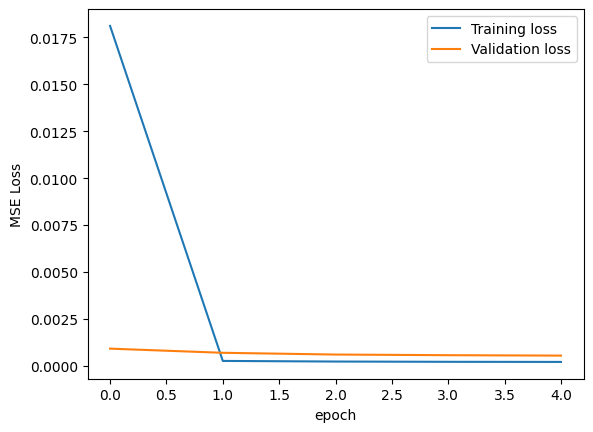

In [89]:
#plt.semilogy(train_loss, label='Training loss')
#plt.semilogy(val_loss, label='Validation loss')
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [90]:
data = get_data('snp500_data.csv', 'Close')

x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(data, lookback)

# reshape to the proper size and transform from np arrays to tensors:
x_train = torch.tensor(x_train.reshape((-1, lookback, 1))).float()
x_val = torch.tensor(x_val.reshape((-1, lookback, 1))).float()
x_test = torch.tensor(x_test.reshape((-1, lookback, 1))).float()

y_train = torch.tensor(y_train.reshape((-1, 1))).float()
y_val = torch.tensor(y_val.reshape((-1, 1))).float()
y_test = torch.tensor(y_test.reshape((-1, 1))).float()

<ipython-input-84-5de44895914e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


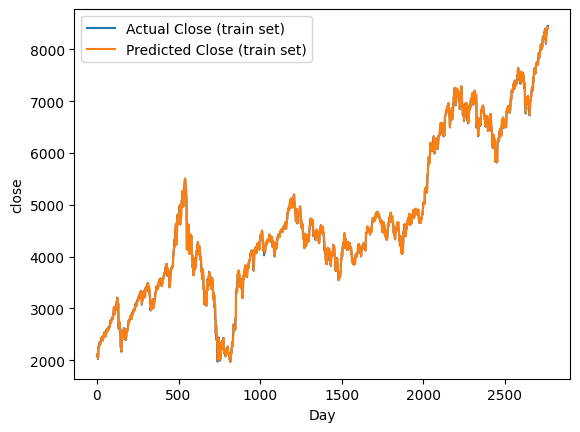

In [91]:

model.train(False)
with torch.no_grad():
  predicted_train = model(x_train.to(device)).to('cpu').numpy()

temp = np.zeros((x_train.shape[0], lookback+1))
temp[:, 0] = predicted_train.flatten()
temp = scaler.inverse_transform(temp)
predicted_train = dc(temp[:,0])

temp[:, 0] = y_train.flatten()
temp = scaler.inverse_transform(temp)
actual_train = dc(temp[:,0])

plt.plot(actual_train, label='Actual Close (train set)')
plt.plot(predicted_train, label='Predicted Close (train set)')
plt.xlabel('Day')
plt.ylabel('close')
plt.legend()
plt.show()


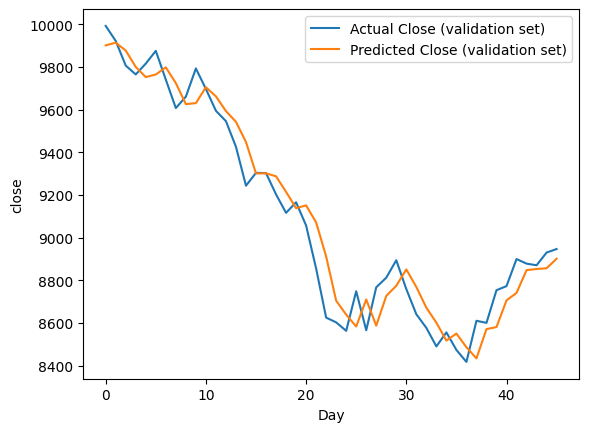

In [92]:
x_val = x_val[300:, :]
y_val = y_val[300:, :]

model.train(False)
with torch.no_grad():
  predicted_test = model(x_val.to(device)).to('cpu').numpy()

temp = np.zeros((x_val.shape[0], lookback+1))
temp[:, 0] = predicted_test.flatten()
temp = scaler.inverse_transform(temp)
predicted_val = dc(temp[:,0])

temp[:, 0] = y_val.flatten()
temp = scaler.inverse_transform(temp)
actual_val = dc(temp[:,0])

plt.plot(actual_val, label='Actual Close (validation set)')
plt.plot(predicted_val, label='Predicted Close (validation set)')
plt.xlabel('Day')
plt.ylabel('close')
plt.legend()
plt.show()